In [2]:
import argparse
from ast import Param
from audioop import reverse
import os
import time
import csv
import torch
from tqdm import tqdm
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.datasets as dset
from cifar_10_1_dataset import load_new_test_data
from learning.wideresnet import WRN34_rot_out_branch
from utils import *
from RandAugment import trans_aug, get_transAug_param
from robustbench.utils import load_model
from robustbench.data import load_cifar10c
from torch.utils.data import Subset
import kornia
from imagecorruptions import corrupt
import matplotlib.pyplot as plt
%matplotlib inline
torch.cuda.set_device(1) 

In [2]:
mu = torch.tensor(cifar10_mean).view(3, 1, 1).cuda()
std = torch.tensor(cifar10_std).view(3, 1, 1).cuda()

In [3]:
class Batches:
    def __init__(self, dataset, batch_size, shuffle, set_random_choices=False, num_workers=0, drop_last=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.set_random_choices = set_random_choices
        self.data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=shuffle,
            drop_last=drop_last
        )

    def __iter__(self):
        if self.set_random_choices:
            self.dataset.set_random_choices()
        return ({'input': x.to(device).float(), 'target': y.to(device).long()} for (x, y) in self.data_loader)

    def __len__(self):
        return len(self.data_loader)

In [4]:
# transforms = [Crop(32, 32)]
dataset = cifar10("../cifar-data")

Files already downloaded and verified
Files already downloaded and verified


In [5]:
corruption_type = ['gaussian_noise', 'shot_noise','impulse_noise',
                      'defocus_blur', 'motion_blur' , 'glass_blur','zoom_blur','snow', 
                      'frost', 'fog', 'brightness', 'contrast', 'elastic_transform',
                      'pixelate', 'jpeg_compression']
    
corruption_type = ['motion_blur' , 'glass_blur','zoom_blur','snow', 
                      'frost', 'fog', 'brightness', 'contrast', 'elastic_transform',
                      'pixelate', 'jpeg_compression']

train_set = list(zip(transpose(pad(dataset['train']['data'], 4) / 255.),
                         dataset['train']['labels']))
train_set_x = Transform(train_set, transforms)
print(len(train_set_x))
train_batches = Batches(train_set_x, 1, shuffle=True, set_random_choices=True, num_workers=2)

test_set = list(zip(transpose(dataset['test']['data'] / 255.), dataset['test']['labels']))
print(len(test_set))
test_batches = Batches(test_set, 10000, shuffle=False, num_workers=2)


50000
10000


In [4]:
from PIL import Image

In [15]:
from robustbench.data import load_cifar10c, load_imagenetc
path = '/local/rcs/yunyun/'
corruption_type = ['gaussian_blur']
x_test, y_test = load_imagenetc(10000, 1, path, False, corruption_type)

FileNotFoundError: [Errno 2] No such file or directory: 'robustbench/data/imagenet_test_image_ids.txt'

In [6]:
import socket
import torchvision.datasets as datasets

if 'thor' in socket.gethostname():
        traindir='/local/rcs/yunyun/ImageNet-Data/train'
        valdir='/local/rcs/yunyun/ImageNet-Data/val'

imgnet_mean=(0.485, 0.456, 0.406)
imgnet_std=(0.229, 0.224, 0.225)

train_dataset = datasets.ImageFolder(
            traindir,
            transforms.Compose([
                transforms.Resize(64), transforms.CenterCrop(64),
                transforms.ToTensor(), ]))#transforms.Normalize(imgnet_mean, imgnet_std),]))

test_dataset = datasets.ImageFolder(
                valdir,
                transforms.Compose([
                    transforms.Resize(64), transforms.CenterCrop(64),
                    transforms.ToTensor(),])) #transforms.Normalize(imgnet_mean, imgnet_std),]))

In [7]:
class_keys = ['n01443537', 'n01494475', 'n01496331', 'n01498041', 
            'n01514859' , 'n01518878', 'n01531178', 'n01532829', 'n01534433', 'n01537544']
    
train_class_idx = [train_dataset.class_to_idx[k] for k in class_keys]
test_class_idx = [test_dataset.class_to_idx[k] for k in class_keys]
print(train_class_idx)
print(test_class_idx)


train_idx = [torch.tensor(train_dataset.targets) == i for i in train_class_idx]
test_idx = [torch.tensor(test_dataset.targets) == i for i in test_class_idx]


train_mask = train_idx[0]
for i in range(1, len(train_idx)): train_mask = train_mask | train_idx[i]
test_mask = test_idx[0]
for i in range(1, len(test_idx)): test_mask = test_mask | test_idx[i]

train_indices = train_mask.nonzero().reshape(-1)   
test_indices = test_mask.nonzero().reshape(-1)

train_subdatasets = Subset(train_dataset, train_indices)
test_subdatasets = Subset(test_dataset, test_indices)

relabel_testsets = []
h = []
for i in range(len(test_subdatasets)):
    relabel_testsets.append([test_subdatasets[i][0], test_class_idx.index(test_subdatasets[i][1])])
    h.append(test_class_idx.index(test_subdatasets[i][1]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 4, 5, 6, 8, 9, 11, 12, 13, 14]


In [8]:
test_loader = Batches(relabel_testsets, 1, shuffle=False, num_workers=2)
file_path = './data/ImageNetC-10cls-ds64/' 
orig_img = []
for i, data in enumerate(test_loader):
    x = data['input']
    y = data['target']
    img = np.transpose(np.array(torch.squeeze(x[0], 0).detach().cpu().numpy()*255, dtype=np.uint8), (1,2,0))
    orig_img.append(img)
        
with open(file_path + 'original.npy', 'wb') as f:
    print('save original test image to : {}'.format(file_path + 'original.npy'))
    np.save(f, np.array(orig_img))

save original test image to : ./data/ImageNetC-10cls-ds64/original.npy


In [10]:
orig_imgs = np.load('./data/ImageNetC-10cls-ds64/original.npy')
print(orig_imgs.shape)

(500, 64, 64, 3)


In [18]:

corruption_type = ['gaussian_noise', 'shot_noise','impulse_noise',
                    'defocus_blur', 'motion_blur' , 'glass_blur', 'zoom_blur',
                     'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform',
                     'pixelate', 'jpeg_compression']

severity = [1,2,3,4,5]

for s in severity:
    for corruption in corruption_type:
        file_path = './data/ImageNetC-10cls-ds64/'+ str(s) + '/' + corruption + '.npy'
        corr_img = []
        count = 0
        for i, data in enumerate(test_loader):
            x = data['input']
            y = data['target']
            npx = np.transpose(np.array(torch.squeeze(x[0], 0).detach().cpu().numpy()*255, dtype=np.uint8), (1,2,0))
            corrupted_image = corrupt(npx, corruption_name=corruption, severity=s)
            corr_img.append(corrupted_image)
            count+=1
        print(np.array(corr_img).shape)
        with open(file_path, 'wb') as f:
            print('save corrupted image to : {}'.format(file_path))
            np.save(f, np.array(corr_img))
    

(500, 64, 64, 3)
save corrupted image to : ./data/ImageNetC-10cls-ds64/1/gaussian_noise.npy
(500, 64, 64, 3)
save corrupted image to : ./data/ImageNetC-10cls-ds64/1/shot_noise.npy
(500, 64, 64, 3)
save corrupted image to : ./data/ImageNetC-10cls-ds64/1/impulse_noise.npy
(500, 64, 64, 3)
save corrupted image to : ./data/ImageNetC-10cls-ds64/1/defocus_blur.npy
(500, 64, 64, 3)
save corrupted image to : ./data/ImageNetC-10cls-ds64/1/motion_blur.npy


/home/yunyuntsai/anaconda3/envs/mytorch/lib/python3.9/site-packages/imagecorruptions/corruptions.py:198: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0.Please use `channel_axis` instead.
  gaussian(np.array(x) / 255., sigma=c[0], multichannel=True) * 255)
/home/yunyuntsai/anaconda3/envs/mytorch/lib/python3.9/site-packages/imagecorruptions/corruptions.py:210: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return np.clip(gaussian(x / 255., sigma=c[0], multichannel=True), 0,


(500, 64, 64, 3)
save corrupted image to : ./data/ImageNetC-10cls-ds64/1/glass_blur.npy
(500, 64, 64, 3)
save corrupted image to : ./data/ImageNetC-10cls-ds64/1/zoom_blur.npy
(500, 64, 64, 3)
save corrupted image to : ./data/ImageNetC-10cls-ds64/1/snow.npy
(500, 64, 64, 3)
save corrupted image to : ./data/ImageNetC-10cls-ds64/1/frost.npy
(500, 64, 64, 3)
save corrupted image to : ./data/ImageNetC-10cls-ds64/1/fog.npy
(500, 64, 64, 3)
save corrupted image to : ./data/ImageNetC-10cls-ds64/1/brightness.npy
(500, 64, 64, 3)
save corrupted image to : ./data/ImageNetC-10cls-ds64/1/contrast.npy
(500, 64, 64, 3)
save corrupted image to : ./data/ImageNetC-10cls-ds64/1/elastic_transform.npy
(500, 64, 64, 3)
save corrupted image to : ./data/ImageNetC-10cls-ds64/1/pixelate.npy
(500, 64, 64, 3)
save corrupted image to : ./data/ImageNetC-10cls-ds64/1/jpeg_compression.npy
(500, 64, 64, 3)
save corrupted image to : ./data/ImageNetC-10cls-ds64/2/gaussian_noise.npy
(500, 64, 64, 3)
save corrupted image 

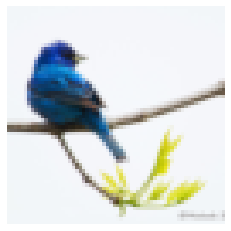

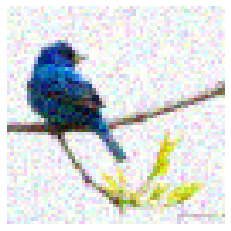

In [17]:
orig_imgs = np.load('./data/ImageNetC-10cls-ds64/original.npy')

# plt.title('without normalize')
plt.axis('off')
# img=normalise(corr_img, imgnet_mean, imgnet_std)
img0 = orig_imgs[499]/ 255.


plt.imshow(img0)
plt.show()
for i in range(1,2):
    corr_imgs = np.load('./data/ImageNetC-10cls-ds64/' + str(i)  + '/gaussian_noise.npy')
    img1= corr_imgs[499]/ 255.
    plt.axis('off')
    plt.imshow(img1)
    plt.show()
# plt.title('with normalize')

plt.show()

In [28]:

test_dataset
h = []
for i in range(len(test_dataset)):
    if i % 50 <5:
        h.append(test_dataset.targets[i])
print(h)


NameError: name 'test_dataset' is not defined

In [11]:
original_file = np.load('./data/ImageNetC-customize/original.npy')
print(original_file.shape)

(50000, 224, 224, 3)


In [47]:

# 0-4 5-9 10-14 15-19 20-24 25-29 30-34 35-39
# 0-49 50-99 100-149 150-199 200-249 250-299 300-349 350-399 
# frost_5_img_167_pred_793-33_param_1.47
corruption_file = np.load('./data/ImageNetC-customize/reversed/saturation/frost_5_img_8_pred_327-1_param_1.47.npy', allow_pickle=True)
# corruption_file = np.load('./data/ImageNetC-customize/reversed/saturation/frost_5_img_91_pred_138-18_param_1.47.npy', allow_pickle=True)

# n02483708 n01608432

In [48]:
imgnet_mean=(0.485, 0.456, 0.406)
imgnet_std=(0.229, 0.224, 0.225)
def normalise(x, mean, std):
    x, mean, std = [np.array(a, np.float32) for a in (x, mean, std)]
    x -= mean * 255
    x *= 1.0 / (255 * std)
    return x

(2, 224, 224, 3)


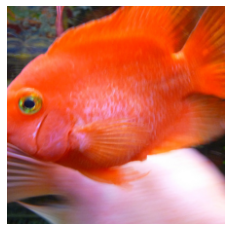

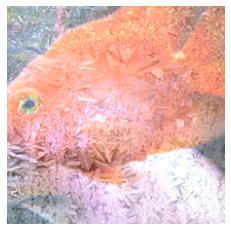

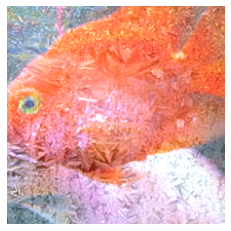

In [49]:
print(corruption_file.shape)
corr_img = corruption_file[0]
rev_img = corruption_file[1]
ori_img = original_file[53]
# plt.title('without normalize')
plt.axis('off')
# img=normalise(corr_img, imgnet_mean, imgnet_std)
img0 = ori_img/ 255.
img1= corr_img/ 255.
img2 = rev_img/ 255.
plt.imshow(img0)
plt.show()
plt.axis('off')
plt.imshow(img1)
plt.show()
# plt.title('with normalize')
plt.imshow(img2)
plt.axis('off')
plt.show()


In [56]:
def apply_pixelate(x, severity=1):
    c = [0.6, 0.5, 0.4, 0.3, 0.25][severity - 1]

    x_shape = np.array(x).shape

    x = x.resize((int(x_shape[1] * c), int(x_shape[0] * c)), Image.BOX)
    print(np.uint8(x).shape)
    plt.title('downsampling resize')
    plt.axis('off')
    plt.imshow(np.uint8(x))
    plt.show()
    x = x.resize((x_shape[1], x_shape[0]), Image.NEAREST)
    plt.title('upsampling resize')
    plt.axis('off')
    plt.imshow(np.uint8(x))
    plt.show()
    return np.uint8(x)

torch.Size([3, 32, 32])
(32, 32, 3)
(32, 32, 3)


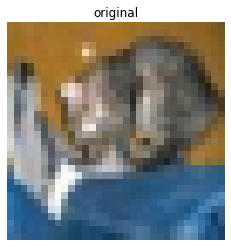

(16, 16, 3)


/home/yunyuntsai/anaconda3/envs/mytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


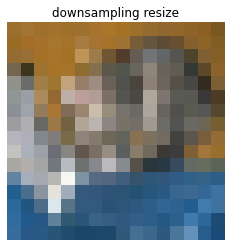

(32, 32, 3)


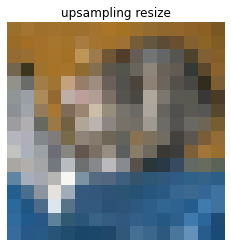

In [57]:
test_ref = next((iter(test_batches)))
print(test_ref['input'][0].shape)
data_dir = './data/'
np_image = np.load(data_dir + 'original.npy')
print(np_image[0].shape)
x = test_ref['input'][0]
x0 = np.transpose(np.array((x.detach().cpu().numpy())*255, dtype=np.uint8), (1,2,0))
print(np.uint8(x0).shape)
plt.title('original')
plt.axis('off')
plt.imshow(np.uint8(x0))
plt.show()
x_shape = test_ref['input'][0].shape
transform = torch.nn.Sequential(transforms.Resize(size=int(x_shape[1]*0.5), interpolation=Image.BILINEAR),)
x = transform(x)
x1 = np.transpose(np.array((x.detach().cpu().numpy())*255, dtype=np.uint8), (1,2,0))
print(np.uint8(x1).shape)
plt.title('downsampling resize')
plt.axis('off')
plt.imshow(np.uint8(x1))
plt.show()
transform = torch.nn.Sequential(transforms.Resize(size=x_shape[1], interpolation=Image.NEAREST),)
x = transform(x)
x2 = np.transpose(np.array((x.detach().cpu().numpy())*255, dtype=np.uint8), (1,2,0))
print(np.uint8(x2).shape)
plt.title('upsampling resize')
plt.axis('off')
plt.imshow(x2)
plt.show()
# print(x.shape)
# x = np.transpose(np.array((test_ref['input'][0].detach().cpu().numpy())*255, dtype=np.uint8), (1,2,0))
# print(np_image[0].shape)
# plt.title('Original')
# plt.axis('off')
# plt.imshow(np_image[0])
# plt.show()
# px = apply_pixelate(Image.fromarray(np_image[0]), 1)
#px = corrupt(np_image[0], corruption_name='pixelate', severity=1)
# print(px.shape)
# with open('original.npy', 'wb') as f:
#     np.save(f, np_image)

In [58]:
original_img_array = np.load('./data/original.npy')
print(original_img_array.shape)

(10000, 32, 32, 3)


In [9]:
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from RandAugment import trans_aug, get_transAug_param
np_image = np.load('./pixelate_test_compare.npy', allow_pickle=True)
corrupted_img_array = np.load('./data/CIFAR-10-C-customize/pixelate.npy')
#np_image = np.transpose(np_image, (1,0,2,3))
idx = np_image[0]
before_imgs = np_image[1]
reverse_imgs = np_image[2]
aug_method = np_image[3]
aug_param = np_image[4]
print(aug_method, aug_param.item())
o_img = original_img_array[idx*64:(idx+1)*64]
for i in range(np_image[1].shape[0]):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6), sharex=False, sharey=False) 
    fig.tight_layout()
    ax = axes.ravel()
#     corr = np.transpose(before_imgs[i], (1,2,0))
    reverse = np.transpose(reverse_imgs[i], (1,2,0))
    corr = np.transpose(before_imgs[i], (1,2,0))
    
    ax[0].imshow(o_img[i])
    ax[0].set_title('orig')
    
#     corr = RandAugment.trans_aug(aug_method, torch.tensor(np.expand_dims(np.transpose(o_img[i]/255, (2,0,1)), axis=0)) , aug_param)
#     corr = np.transpose(np.array(torch.squeeze(corr, 0).detach().cpu().numpy()*255, dtype=np.uint8), (1,2,0))
    ax[1].imshow(corr)
    ax[1].set_title('corruption: pixelate')
#   ax[1].set_xlabel('param: '+ aug_method + ' {0:0.3f}'.format(aug_param.item()))


    ax[2].imshow(reverse)
    ax[2].set_title('reverse \n best param: '+ aug_method + ' {0:0.3f}'.format(aug_param.item()))
    cosim = cos_sim(o_img[i].ravel().reshape(1,-1), reverse.ravel().reshape(1,-1))[0][0]
    ax[2].set_xlabel('cosine similarity:{0:0.5f}'.format(cosim))
    
    
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './pixelate_test_compare.npy'

(2, 625)
2.86 0.64
3.43 0.69


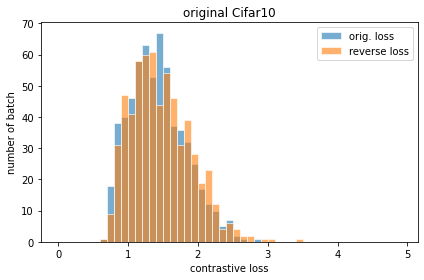

In [29]:
loss_list = np.load('./loss_histogram/cifar10c_orig.npy', allow_pickle=True)
print(loss_list.shape)
orig_loss = np.round(loss_list[0],2)
# corr_loss = loss_list[1]
reverse_loss = np.round(loss_list[1],2)
print(orig_loss.max(), orig_loss.min())
# print(corr_loss.max(), corr_loss.min())
print(reverse_loss.max(), reverse_loss.min())


import matplotlib.pyplot as plt 
plt.hist(orig_loss, bins=np.arange(50)/10, edgecolor="white",alpha = 0.6, label='orig. loss')
plt.hist(reverse_loss, bins=np.arange(50)/10, edgecolor="white",alpha = 0.6, label='reverse loss')
plt.title('original Cifar10')
plt.xlabel('contrastive loss')
plt.ylabel('number of batch')
plt.legend()
plt.tight_layout()
plt.show()

3.97 2.05
4.01 2.03


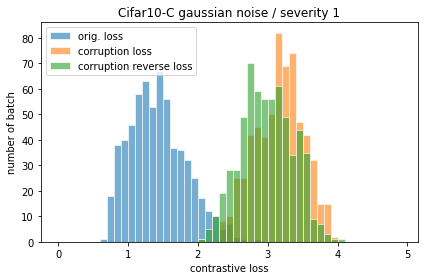

4.2 2.94
4.13 2.79


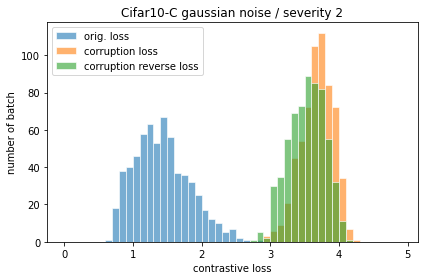

4.23 3.42
4.19 3.43


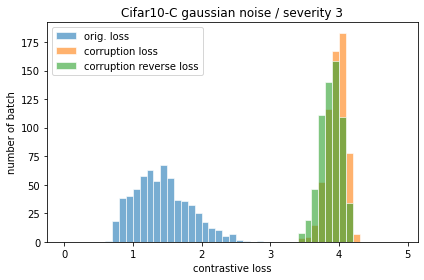

4.27 3.76
4.28 3.74


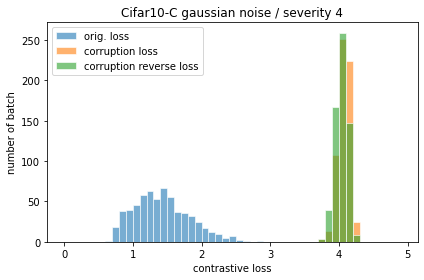

4.26 3.92
4.26 3.9


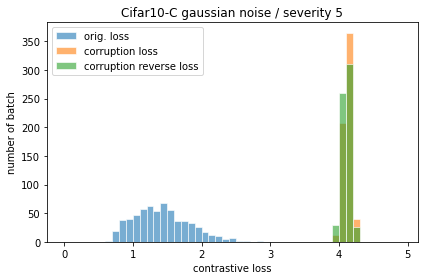

In [24]:
severity = [1,2,3,4,5]
for s in severity:
    loss_list = np.load('./loss_histogram/cifar10c_gaussian_noise_s' + str(s) +'.npy', allow_pickle=True)
    corrupt_loss = np.round(loss_list[0],2)
    # corr_loss = loss_list[1]
    corrupt_reverse_loss = np.round(loss_list[1],2)
    print(corrupt_loss.max(), corrupt_loss.min())
    # print(corr_loss.max(), corr_loss.min())
    print(corrupt_reverse_loss.max(), corrupt_reverse_loss.min())

    plt.hist(orig_loss, bins=np.arange(50)/10, edgecolor="white",alpha = 0.6, label='orig. loss')
    plt.hist(corrupt_loss, bins=np.arange(50)/10, edgecolor="white",alpha = 0.6, label='corruption loss')
    plt.hist(corrupt_reverse_loss, bins=np.arange(50)/10, edgecolor="white",alpha = 0.6, label='corruption reverse loss')
    plt.title('Cifar10-C gaussian noise / severity ' + str(s))
    plt.xlabel('contrastive loss')
    plt.ylabel('number of batch')
    plt.legend()
    plt.tight_layout()
    plt.show()

3.29 0.93
3.06 0.85


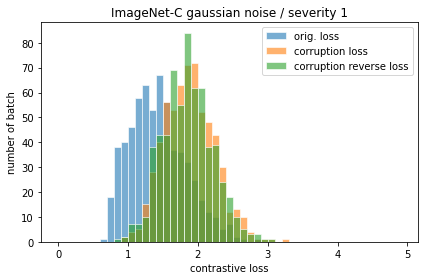

3.43 1.22
3.17 1.09


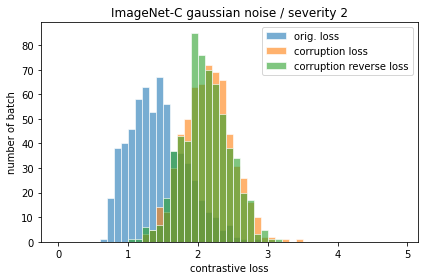

3.43 1.43
3.34 1.39


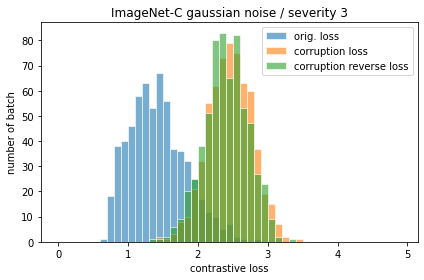

3.48 1.84
3.48 1.76


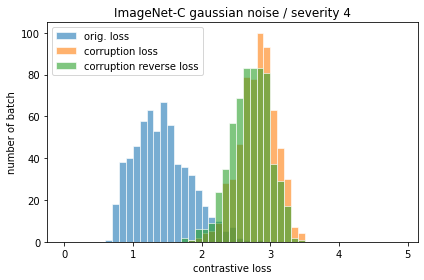

3.66 2.38
3.63 2.13


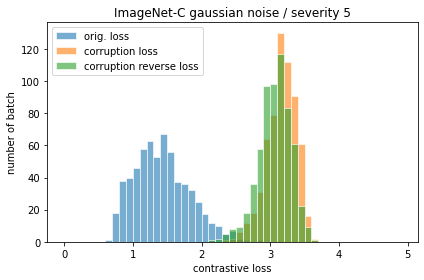

In [26]:
severity = [1,2,3,4,5]
for s in severity:
    loss_list = np.load('./loss_histogram/imnetc_gaussian_noise_s' + str(s) +'.npy', allow_pickle=True)
    corrupt_loss = np.round(loss_list[0],2)
    # corr_loss = loss_list[1]
    corrupt_reverse_loss = np.round(loss_list[1],2)
    print(corrupt_loss.max(), corrupt_loss.min())
    # print(corr_loss.max(), corr_loss.min())
    print(corrupt_reverse_loss.max(), corrupt_reverse_loss.min())

    plt.hist(orig_loss, bins=np.arange(50)/10, edgecolor="white",alpha = 0.6, label='orig. loss')
    plt.hist(corrupt_loss, bins=np.arange(50)/10, edgecolor="white",alpha = 0.6, label='corruption loss')
    plt.hist(corrupt_reverse_loss, bins=np.arange(50)/10, edgecolor="white",alpha = 0.6, label='corruption reverse loss')
    plt.title('ImageNet-C gaussian noise / severity ' + str(s))
    plt.xlabel('contrastive loss')
    plt.ylabel('number of batch')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [67]:
loss_list = np.load('./loss_histogram/gaussiannoise_loss_hitogram.npy', allow_pickle=True)
loss_list = np.transpose(loss_list, (1,0))
print(loss_list.shape)
orig_loss = loss_list[0]
corr_loss = loss_list[1]
reverse_loss = loss_list[2]
print(orig_loss.max(), orig_loss.min())
print(corr_loss.max(), corr_loss.min())
print(reverse_loss.max(), reverse_loss.min())

print(np.sort(loss_list[0]*100))
bin_orig_loss = loss_list[0]*100//2
bin_corr_loss = loss_list[1]*100//2
bin_reverse_loss = loss_list[2]*100//2
print(bin_reverse_loss.min(), bin_reverse_loss.max())
print(bin_corr_loss.min(), bin_corr_loss.max())
print(bin_orig_loss.min(), bin_orig_loss.max())

(3, 313)
0.8098047375679016 0.4221266806125641
2.766815662384033 1.6619844436645508
1.7915536165237427 1.0474019050598145
[42.21266806 43.16134155 44.32423413 44.93482411 46.01197839 46.03416324
 46.72290683 46.73601389 46.85063064 47.16307521 47.20619619 47.4219501
 47.43608832 47.47848213 47.5206852  47.53336608 47.72825241 47.82424569
 47.86049426 48.00593853 48.10223877 48.16869795 48.1906265  48.29953909
 48.33495319 48.54950011 48.87767136 48.89112711 49.17823076 49.4349122
 49.49187636 49.84618723 49.96992648 50.01645684 50.36364198 50.44944882
 50.62983632 50.64542294 50.65221786 50.66606998 50.78668594 50.83494782
 50.92507601 51.11727118 51.17158294 51.23932362 51.2706399  51.29605532
 51.38876438 51.5171349  51.53954029 51.59499049 51.60921216 51.66839361
 51.68795586 51.76167488 51.85658932 51.86172128 51.8964529  51.91482306
 51.97791457 52.03794837 52.06505656 52.12187767 52.13369131 52.17201114
 52.24840641 52.28677988 52.38836408 52.42103338 52.47567892 52.51104236
 52.

In [68]:
from matplotlib.backends.backend_pdf import PdfPages

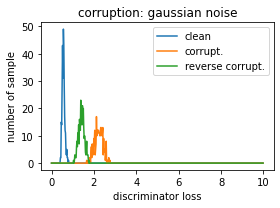

In [80]:
pp = PdfPages('loss_distribution.pdf')

lcount_orig = np.zeros(500)
lcount_corr = np.zeros(500)
lcount_reverse = np.zeros(500)
for i in range(bin_orig_loss.shape[0]): lcount_orig[int(bin_orig_loss[i])] += 1
for i in range(bin_corr_loss.shape[0]): lcount_corr[int(bin_corr_loss[i])] += 1
for i in range(bin_reverse_loss.shape[0]): lcount_reverse[int(bin_reverse_loss[i])] += 1
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3), sharex=False, sharey=False)  
ax.plot(np.arange(500)*2/100, lcount_orig, label='clean')
ax.plot(np.arange(500)*2/100, lcount_corr, label='corrupt.')
ax.plot(np.arange(500)*2/100, lcount_reverse, label='reverse corrupt.')
ax.legend()
plt.title('corruption: gaussian noise')
plt.xlabel('discriminator loss')
plt.ylabel('number of sample')
plt.tight_layout()
plt.show()
# plt.savefig('loss_distribution.pdf') 
pp.savefig(fig)

pp.close()

(15, 2000, 2)
ROC AUC=0.845
ROC AUC=0.859
ROC AUC=0.654
ROC AUC=1.000
ROC AUC=0.988
ROC AUC=0.999
ROC AUC=0.973
ROC AUC=0.591
ROC AUC=0.709
ROC AUC=0.907
ROC AUC=0.792
ROC AUC=0.856
ROC AUC=0.713
ROC AUC=0.997
ROC AUC=0.957


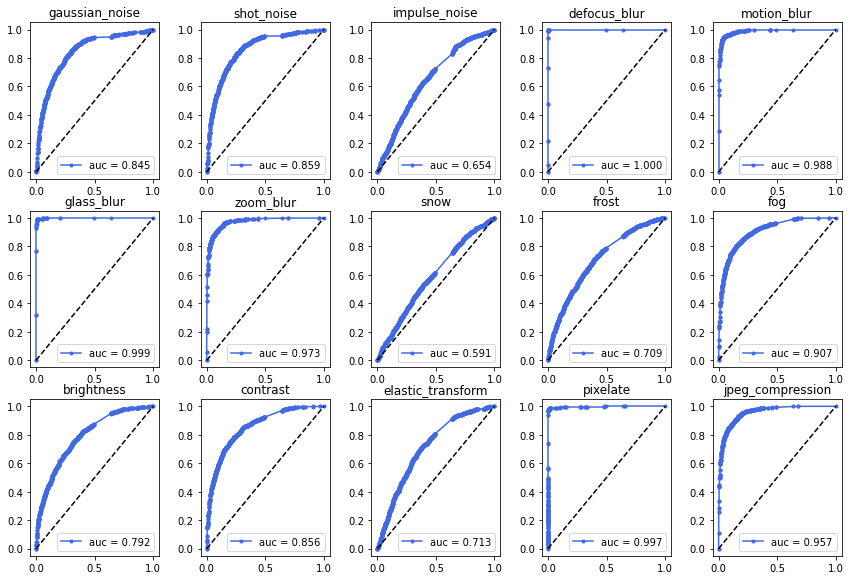

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

corruption_type = ['gaussian_noise', 'shot_noise','impulse_noise',
                      'defocus_blur', 'motion_blur' , 'glass_blur','zoom_blur','snow', 
                      'frost', 'fog', 'brightness', 'contrast', 'elastic_transform',
                      'pixelate', 'jpeg_compression']
all_tpr_fpr_list = np.load('./loss_histogram/cifar10_1_mixed_all_tpr_fpr_s1.npy', allow_pickle=True)
all_tpr_fpr_list_s3 = np.load('./loss_histogram/cifar10_1_mixed_all_tpr_fpr_s3.npy', allow_pickle=True)
all_tpr_fpr_list_s5 = np.load('./loss_histogram/cifar10_1_mixed_all_tpr_fpr_s5.npy', allow_pickle=True)
print(all_tpr_fpr_list.shape)
FPR_list = []
TPR_list = []
AUC_list = []

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
fig.tight_layout() 
for i in range(15):

    tpr_fpr_list = all_tpr_fpr_list[i]
    ytrue = tpr_fpr_list[:,0]
    probs = tpr_fpr_list[:,1]   
    
    if i == 10:
        tpr_fpr_list = all_tpr_fpr_list_s5[i]
        ytrue = tpr_fpr_list[:,0]
        probs = tpr_fpr_list[:,1]

    auc = roc_auc_score(ytrue, probs)
    # summarize scores
    print('ROC AUC=%.3f' % (auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(ytrue, probs)
    FPR_list.append(lr_fpr)
    TPR_list.append(lr_tpr)
    AUC_list.append(auc)
   

idx = 0
for j in range(3):
    for k in range(5):
        # plot the roc curve for the model
        axs[j, k].plot(FPR_list[idx], TPR_list[idx], marker='.', color='royalblue', label="auc = {0:0.3f}".format(AUC_list[idx]))
        axs[j, k].plot([0, 1], [0, 1], "k--")
        # axis labels
        axs[j, k].set_title(str(corruption_type[idx]))
#        axs[j, k].set_xlabel('False Positive Rate')
#        axs[j, k].set_ylabel('True Positive Rate')
        idx+=1
        # show the legend
        axs[j, k].legend()
            # show the plot
plt.show()
pp = PdfPages('cifar10c_all_roc_curve.pdf')
pp.savefig(fig)
pp.close()

s1 ROC AUC=0.837
s3 ROC AUC=0.917
s5 ROC AUC=0.925
0.17986945807933807


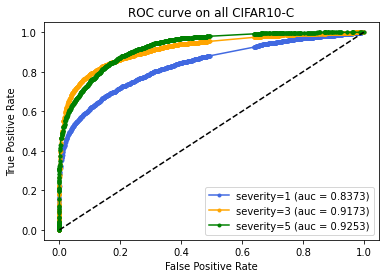

In [38]:
tpr_fpr_list_0 = all_tpr_fpr_list[0]
Ytrue = tpr_fpr_list_0[:,0]
Probs = tpr_fpr_list_0[:,1] 

tpr_fpr_list_s3_0 = all_tpr_fpr_list_s3[0]
Ytrue_s3 = tpr_fpr_list_s3_0[:,0]
Probs_s3 = tpr_fpr_list_s3_0[:,1] 

tpr_fpr_list_s5_0 = all_tpr_fpr_list_s5[0]
Ytrue_s5 = tpr_fpr_list_s5_0[:,0]
Probs_s5 = tpr_fpr_list_s5_0[:,1] 

for i in range(1, 15):
    tpr_fpr_list = all_tpr_fpr_list[i]
    tpr_fpr_list_s3 = all_tpr_fpr_list_s3[i]
    tpr_fpr_list_s5 = all_tpr_fpr_list_s5[i]
    
    ytrue = tpr_fpr_list[:,0]
    probs = tpr_fpr_list[:,1]
    
    ytrue_s3 = tpr_fpr_list_s3[:,0]
    probs_s3 = tpr_fpr_list_s3[:,1]
    
    ytrue_s5 = tpr_fpr_list_s5[:,0]
    probs_s5 = tpr_fpr_list_s5[:,1]

    Ytrue = np.concatenate((Ytrue, ytrue), axis=0)
    Probs = np.concatenate((Probs, probs), axis=0)
    
    Ytrue_s3 = np.concatenate((Ytrue_s3, ytrue_s3), axis=0)
    Probs_s3 = np.concatenate((Probs_s3, probs_s3), axis=0)
    
    Ytrue_s5 = np.concatenate((Ytrue_s5, ytrue_s5), axis=0)
    Probs_s5 = np.concatenate((Probs_s5, probs_s5), axis=0)

auc = roc_auc_score(Ytrue, Probs)
auc_s3 = roc_auc_score(Ytrue_s3, Probs_s3)
auc_s5 = roc_auc_score(Ytrue_s5, Probs_s5)
# summarize scores
print('s1 ROC AUC=%.3f' % (auc))
print('s3 ROC AUC=%.3f' % (auc_s3))
print('s5 ROC AUC=%.3f' % (auc_s5))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(Ytrue, Probs)
lr_fpr_s3, lr_tpr_s3, thr = roc_curve(Ytrue_s3, Probs_s3)
lr_fpr_s5, lr_tpr_s5, _ = roc_curve(Ytrue_s5, Probs_s5)
# plot the roc curve for the model
print(thr[-1])
fig = plt.figure()
plt.plot(lr_fpr, lr_tpr, marker='.', color='royalblue', label="severity={0:0d} (auc = {1:0.4f})".format(1, auc))
plt.plot(lr_fpr_s3, lr_tpr_s3, marker='.', color='orange',  label="severity={0:0d} (auc = {1:0.4f})".format(3, auc_s3))
plt.plot(lr_fpr_s5, lr_tpr_s5, marker='.', color='green', label="severity={0:0d} (auc = {1:0.4f})".format(5, auc_s5))
plt.plot([0, 1], [0, 1], "k--")
# axis labels
plt.title('ROC curve on all CIFAR10-C')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
 
# plt.savefig('cifar10c_roc_curve.pdf', bbox_inches='tight')
pp1 = PdfPages('cifar10c_roccurve.pdf')
pp1.savefig(fig)
pp1.close()

(10000, 32, 32, 3)


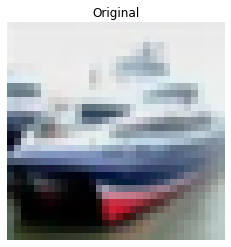

In [46]:
from imagecorruptions import get_corruption_names

data_dir = './data/'
np_image = np.load(data_dir + 'original.npy')
print(np_image.shape)
plt.title('Original')
plt.axis('off')
plt.imshow(np_image[1])
plt.show()
# for corruption in corruption_type:
#     co_list = []
#     for s in range(5):
#         corrupted_image = [corrupt(np_image[i], corruption_name=corruption, severity=s+1) for i in range(np_image.shape[0])]
#         co_list.append(corrupted_image)
#     print(np.array(co_list).shape)
#     file_path = data_dir + corruption + '.npy'
#     with open(file_path, 'wb') as f:
#         print('save corrupted image to : {}'.format(file_path))
#         np.save(f, np.array(co_list))
# print('finished to generate corrupted image!')

In [47]:
class_map = {
    0 : 'airplane',
    1 : 'automobile', 
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

In [48]:
def show_image(o_img, c_img, r_img, label, corr_pred, rev_pred):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), sharex=True, sharey=True)  
    ax = axes.ravel()

    mse_none = mean_squared_error(o_img, o_img)
    ssim_none = ssim(o_img, o_img, multichannel=True, data_range=o_img.max() - o_img.min())
    cosim_none = cos_sim(o_img.ravel().reshape(1,-1), o_img.ravel().reshape(1,-1))[0][0]
#     print(mse_none, ssim_none, cosim_none)

    mse_corrupt = mean_squared_error(o_img, c_img)
    ssim_corrupt = ssim(o_img, c_img, multichannel=True, data_range=c_img.max() - c_img.min())
    cosim_corrupt = cos_sim(o_img.ravel().reshape(1,-1), c_img.ravel().reshape(1,-1))[0][0]
#     print(mse_corrupt, ssim_corrupt)

    mse_reverse = mean_squared_error(o_img, r_img)
    ssim_reverse = ssim(o_img, r_img, multichannel=True, data_range=r_img.max() - r_img.min())
    cosim_reverse = cos_sim(o_img.ravel().reshape(1,-1), r_img.ravel().reshape(1,-1))[0][0]
#     print(mse_reverse, ssim_reverse)

    ax[0].imshow(o_img)
    ax[0].set_xlabel(f'label: {class_map[label.item()]},\n MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}, cos_sim: {cosim_none:.2f}')
    ax[0].set_title('Original')

    ax[1].imshow(c_img)
    ax[1].set_xlabel(f'pred: {class_map[int(corr_pred)]},\n MSE: {mse_corrupt:.2f}, SSIM: {ssim_corrupt:.2f}, cos_sim: {cosim_corrupt:.2f}')
    ax[1].set_title('Image with corruption')

    ax[2].imshow(r_img)
    ax[2].set_xlabel(f'pred: {class_map[int(rev_pred)]},\n MSE: {mse_reverse:.2f}, SSIM: {ssim_reverse:.2f}, cos_sim: {cosim_reverse:.2f}')
    ax[2].set_title('Reversed image from corruption')

    plt.tight_layout()
    plt.show()

In [59]:
def read_image(img_file, corrupted_img_array):
    
    severity = int(img_file.split("_")[1])
    idx = int(img_file.split("_")[3])
    corr_pred, rev_pred  = img_file.split("_")[5].split("-")
    param = img_file.split("_")[7].split(".npy")[0]
    label = test_ref['target'][idx]
    
    reversed_img = np.load(os.path.join(reversed_root_path, img_file))
    original_img = original_img_array[idx]
    corrupted_img = corrupted_img_array[severity][idx]

    o_img = img_as_float(original_img)
    c_img = img_as_float(corrupted_img)
    r_img = img_as_float(reversed_img)
    return o_img, c_img, r_img, label, corr_pred, rev_pred

In [60]:
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from skimage.metrics import mean_squared_error
from skimage import data, img_as_float


(5,)


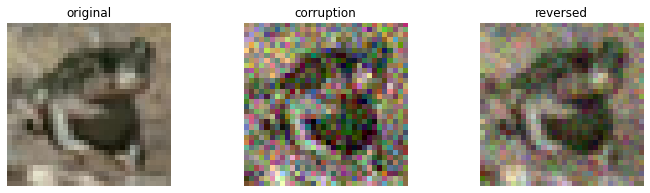

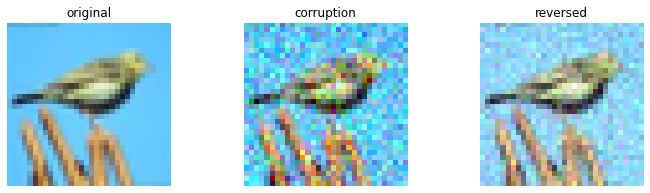

In [64]:
from matplotlib.backends.backend_pdf import PdfPages
reversed_root_path = './data/CIFAR-10-C-customize/reversed/'
reversed_file = os.listdir(reversed_root_path)
file_path1 = os.path.join(reversed_root_path, 'reversed_success_gan_joint_gaussian_noise.npy')

file_path2 = os.path.join(reversed_root_path, 'reversed_fail_gan_joint_gaussian_noise.npy')
# file_path2 = os.path.join(reversed_root_path, 'reversed_success.npy')

corrupted_img_array = np.load('./data/CIFAR-10-C-customize/gaussian_noise.npy')
reverse_success = np.load(file_path1, allow_pickle=True)
print(reverse_success[0].shape)
reverse_fail = np.load(file_path2, allow_pickle=True)
eps = [[0.1, 2.5], [0.1, 0.5], [0.7, 1.3]]

# fig = plt.figure()
# pp = PdfPages("./outputs/plots.pdf")
pp = PdfPages('cifar10c_reversed_sample.pdf')
for i in range(32,34):
    idx = reverse_success[i][0]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3), sharex=False, sharey=False)  
    ax = axes.ravel()
    ax[0].axis('off')
    ax[0].imshow(original_img_array[idx])
    
    ax[0].set_title('original')
    
    ax[1].axis('off')
    ax[1].imshow(corrupted_img_array[1][idx])
    ax[1].set_title('corruption')
    
    ax[2].axis('off')
    ax[2].imshow(reverse_success[i][1])
    ax[2].set_title('reversed')
    if reverse_success[i][2][0] == reverse_success[i][4][0][0]:
        rmethod = 'contrast'
    if reverse_success[i][2][0] == reverse_success[i][4][1][0]:
        rmethod = 'sharpness'
    if reverse_success[i][2][0] == reverse_success[i][4][2][0]:
        rmethod = 'saturation'
    ax[2].set_xlabel(f'choice: {rmethod, np.round(reverse_success[i][2][0], decimals=2)}')

#     for j in range(3,6):  

#         param = (np.arange(20)/20) * (eps[j%3][1] - eps[j%3][0]) + eps[j%3][0]
#         ax[j].plot(param,reverse_success[i][3][j%3][0], label='dloss')
#         ax[j].plot(param, reverse_success[i][3][j%3][1], label='sloss')
#         ax[j].plot(param, reverse_success[i][3][j%3][2], label='joint')
#         ax[j].legend()
#         if j%3==0:
#             ax[j].set_title('contrast')
#         if j%3==1:
#             ax[j].set_title('sharpness')
#         if j%3==2:
#             ax[j].set_title('saturation')
       
    
    #     ax[3].set_xticks(reverse_success[i][3][2])
    #     ax[3].set_xticklabels(param)
    
#         x0,x1 = ax[j].get_xlim()
#         y0,y1 = ax[j].get_ylim()
#         ax[j].set_aspect(abs(x1-x0)/abs(y1-y0))

#     pp.savefig(fig)
    plt.axis('off')
    plt.show()

# pp.close()
# plt.title('reversed')
   
# plt.imshow(img[3][0])
# print(loss_track[3][0])
# plt.figure()
# plt.plot(loss_track[3][0], label='loss trace')
# plt.legend()
# plt.show()
# for img_file in reversed_file:
#     print(img_file)
#     if img_file != 'old':
#         corrupted_img_array = np.load('./data/CIFAR-10-C-customize/contrast.npy')
#         o_img, c_img, r_img, label, corr_pred, rev_pred = read_image(img_file, corrupted_img_array)

    pp.savefig(fig)

pp.close()

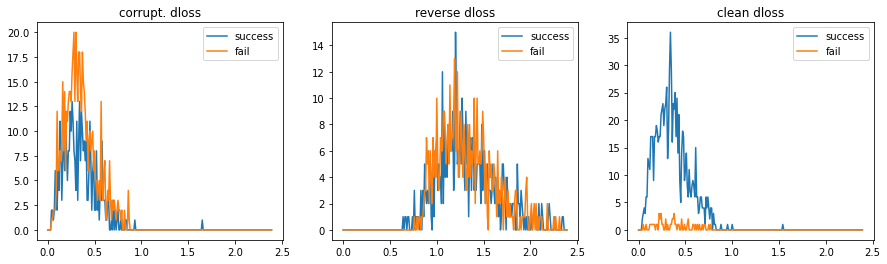

In [44]:
from matplotlib.backends.backend_pdf import PdfPages
reversed_root_path = './data/CIFAR-10-C-customize/reversed/'
reversed_file = os.listdir(reversed_root_path)
file_path1 = os.path.join(reversed_root_path, 'orig_success_loss_gaussian_noise.npy')

file_path2 = os.path.join(reversed_root_path, 'orig_fail_loss_gaussian_noise.npy')

file_path3 = os.path.join(reversed_root_path, 'reversed_success_gan_joint_gaussian_noise.npy')

file_path4 = os.path.join(reversed_root_path, 'reversed_fail_gan_joint_gaussian_noise.npy')

file_path5 = os.path.join(reversed_root_path, 'clean_success_loss.npy')

file_path6 = os.path.join(reversed_root_path, 'clean_fail_loss.npy')
# file_path2 = os.path.join(reversed_root_path, 'reversed_success.npy')

corrupted_img_array = np.load('./data/CIFAR-10-C-customize/gaussian_noise.npy')
clean_success = np.load(file_path5, allow_pickle=True)
clean_fail = np.load(file_path6, allow_pickle=True)
orig_success = np.load(file_path1, allow_pickle=True)
orig_fail = np.load(file_path2, allow_pickle=True)
reverse_success = np.load(file_path3, allow_pickle=True)
reverse_fail = np.load(file_path4, allow_pickle=True)


aug = ['contrast', 'sharpness', 'saturation']
reverse_success_dloss = np.array([np.mean(reverse_success[i][3][0][aug.index(reverse_success[i][2][1])]) for i in range(reverse_success.shape[0])])
reverse_fail_dloss = np.array([np.mean(reverse_fail[i][3][0][aug.index(reverse_fail[i][2][1])]) for i in range(reverse_fail.shape[0])])

clean_success_arr = np.zeros((240))
clean_fail_arr = np.zeros((240))
count_success_arr = np.zeros((240))
count_fail_arr = np.zeros((240))
rcount_success_arr = np.zeros(240)
rcount_fail_arr = np.zeros(240)

for i in range(clean_success.shape[0]): clean_success_arr[int(np.round(clean_success[i]*100,0))] += 1
for i in range(clean_fail.shape[0]): clean_fail_arr[int(np.round(clean_fail[i]*100,0))] += 1    

for i in range(orig_success.shape[0]): count_success_arr[int(np.round(orig_success[i]*100,0))] += 1
for i in range(orig_fail.shape[0]): count_fail_arr[int(np.round(orig_fail[i]*100,0))] += 1
    
for i in range(reverse_success_dloss.shape[0]): rcount_success_arr[int(np.round(reverse_success_dloss[i]*100,0))] += 1
for i in range(reverse_fail_dloss.shape[0]): rcount_fail_arr[int(np.round(reverse_fail_dloss[i]*100,0))] += 1


eps = [[0.1, 2.5], [0.1, 0.5], [0.7, 1.3]]

# pp = PdfPages("./outputs/plots.pdf")
for i in range(0,1):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=False, sharey=False)  
    ax = axes.ravel()
#     ax[0].imshow(original_img_array[idx])
#     ax[0].set_title('original')

#     ax[1].imshow(corrupted_img_array[1][idx])
#     ax[1].set_title('corruption')

#     ax[2].imshow(reverse_success[i][1])
#     ax[2].set_title('reversed')
#     ax[2].set_xlabel(f'choice: {reverse_success[i][2]},\n {reverse_success[i][4]}')


    x1 = (np.arange(240)/100)
    x2 = (np.arange(240)/100)
    ax[0].plot(x1, count_success_arr, label='success')  
    ax[0].plot(x1, count_fail_arr, label='fail')
    ax[0].legend()
    ax[0].set_title('corrupt. dloss')

    #     ax[3].set_xticks(reverse_success[i][3][2])
    #     ax[3].set_xticklabels(param)
    
#     x0,x1 = ax[0].get_xlim()
#     y0,y1 = ax[0].get_ylim()
#     ax[0].set_aspect(abs(x1-x0)/abs(y1-y0))
      
    ax[1].plot(x2, rcount_success_arr, label='success')  
    ax[1].plot(x2, rcount_fail_arr, label='fail')
    ax[1].legend()
    ax[1].set_title('reverse dloss')
      
#     x0,x1 = ax[1].get_xlim()
#     y0,y1 = ax[1].get_ylim()
#     ax[1].set_aspect(abs(x1-x0)/abs(y1-y0))
    
    ax[2].plot(x2, clean_success_arr, label='success')  
    ax[2].plot(x2, clean_fail_arr, label='fail')
    ax[2].legend()
    ax[2].set_title('clean dloss')
      
#     x0,x1 = ax[2].get_xlim()
#     y0,y1 = ax[2].get_ylim()
#     ax[2].set_aspect(abs(x1-x0)/abs(y1-y0))

#     pp.savefig(fig)
    plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
reversed_root_path = './data/CIFAR-10-C-customize/reversed/'
reversed_file = os.listdir(reversed_root_path)
file_path1 = os.path.join(reversed_root_path, 'clean_success_sloss_gaussian_noise.npy')
file_path2 = os.path.join(reversed_root_path, 'clean_fail_sloss_gaussian_noise.npy')
clean_success_sloss = np.load(file_path1, allow_pickle=True)
clean_fail_sloss = np.load(file_path2, allow_pickle=True)

clean_success_sloss = np.mean(clean_success_sloss, axis=-1)
clean_fail_sloss = np.mean(clean_fail_sloss, axis=-1)
print(clean_success_sloss.shape)
print(clean_fail_sloss.shape)

clean_count_success = np.zeros((3,350))
clean_count_fail = np.zeros((3,350))

for j in range(0,3):
    sloss_success = clean_success_sloss[:,j]
    print(sloss_success.shape)
    sloss_fail = clean_fail_sloss[:,j]
    print(sloss_fail.shape)
    for i in range(clean_success_sloss.shape[0]): clean_count_success[j][int(np.round(sloss_success[i]*100,0))] += 1
    for i in range(clean_fail_sloss.shape[0]): clean_count_fail[j][int(np.round(sloss_fail[i]*100,0))] += 1 
# pp = PdfPages("./outputs/plots.pdf")

for i in range(0,1):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=False, sharey=False)  
    ax = axes.ravel()
#     ax[0].imshow(original_img_array[idx])
#     ax[0].set_title('original')

#     ax[1].imshow(corrupted_img_array[1][idx])
#     ax[1].set_title('corruption')

#     ax[2].imshow(reverse_success[i][1])
#     ax[2].set_title('reversed')
#     ax[2].set_xlabel(f'choice: {reverse_success[i][2]},\n {reverse_success[i][4]}')


    x1 = (np.arange(350)/100)
    x2 = (np.arange(350)/100)
    ax[0].plot(x1, clean_count_success[0], label='success')  
    ax[0].plot(x1, clean_count_fail[0], label='fail')
    ax[0].legend()
    ax[0].set_title('clean sloss')

    #     ax[3].set_xticks(reverse_success[i][3][2])
    #     ax[3].set_xticklabels(param)
    
#     x0,x1 = ax[0].get_xlim()
#     y0,y1 = ax[0].get_ylim()
#     ax[0].set_aspect(abs(x1-x0)/abs(y1-y0))
      
    ax[1].plot(x2, clean_count_success[1], label='success')  
    ax[1].plot(x2, clean_count_fail[1], label='fail')
    ax[1].legend()
    ax[1].set_title('clean sloss')
      
#     x0,x1 = ax[1].get_xlim()
#     y0,y1 = ax[1].get_ylim()
#     ax[1].set_aspect(abs(x1-x0)/abs(y1-y0))
    
    ax[2].plot(x2, clean_count_success[2], label='success')  
    ax[2].plot(x2, clean_count_fail[2], label='fail')
    ax[2].legend()
    ax[2].set_title('clean sloss')
      
#     x0,x1 = ax[2].get_xlim()
#     y0,y1 = ax[2].get_ylim()
#     ax[2].set_aspect(abs(x1-x0)/abs(y1-y0))

#     pp.savefig(fig)
    plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
reversed_root_path = './data/CIFAR-10-C-customize/reversed/'
reversed_file = os.listdir(reversed_root_path)
file_path1 = os.path.join(reversed_root_path, 'orig_success_allloss_gaussian_noise.npy')
file_path2 = os.path.join(reversed_root_path, 'orig_fail_allloss_gaussian_noise.npy')
success_loss = np.transpose(np.load(file_path1, allow_pickle=True), (1,0,2,3)) #dloss / sloss/ joinloss
fail_loss = np.transpose(np.load(file_path2, allow_pickle=True), (1,0,2,3))

loss_func = ['dloss', 'sloss', 'joint']
for k in range(0,3):

    reverse_success_loss = np.mean(success_loss[k], axis=-1)
    reverse_fail_loss = np.mean(fail_loss[k], axis=-1)
#     print(reverse_success_loss.shape)
#     print(reverse_fail_loss.shape)

    count_success = np.zeros((3,350))
    count_fail = np.zeros((3,350))

    for j in range(0,3):
        loss_success = reverse_success_loss[:,j]
#         print(loss_success.shape)
        loss_fail = reverse_fail_loss[:,j]
#         print(loss_fail.shape)
        for i in range(reverse_success_loss.shape[0]): count_success[j][int(np.round(loss_success[i]*100,0))] += 1
        for i in range(reverse_fail_loss.shape[0]): count_fail[j][int(np.round(loss_fail[i]*100,0))] += 1 
    # pp = PdfPages("./outputs/plots.pdf")

    for i in range(0,1):
        
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=False, sharey=False)  
        ax = axes.ravel()
    #     ax[0].imshow(original_img_array[idx])
    #     ax[0].set_title('original')

    #     ax[1].imshow(corrupted_img_array[1][idx])
    #     ax[1].set_title('corruption')

    #     ax[2].imshow(reverse_success[i][1])
    #     ax[2].set_title('reversed')
    #     ax[2].set_xlabel(f'choice: {reverse_success[i][2]},\n {reverse_success[i][4]}')


        x1 = (np.arange(350)/100)
        x2 = (np.arange(350)/100)
        ax[0].plot(x1, count_fail[0], label='fail')
        ax[0].plot(x1, count_success[0], label='success') 
         

        ax[0].legend()
        ax[0].set_title('orig '+loss_func[k])

        #     ax[3].set_xticks(reverse_success[i][3][2])
        #     ax[3].set_xticklabels(param)

    #     x0,x1 = ax[0].get_xlim()
    #     y0,y1 = ax[0].get_ylim()
    #     ax[0].set_aspect(abs(x1-x0)/abs(y1-y0))
        ax[1].plot(x2, count_fail[1], label='fail')
        ax[1].plot(x2, count_success[1], label='success') 

        

        ax[1].legend()
        ax[1].set_title('orig '+loss_func[k])

    #     x0,x1 = ax[1].get_xlim()
    #     y0,y1 = ax[1].get_ylim()
    #     ax[1].set_aspect(abs(x1-x0)/abs(y1-y0))
        ax[2].plot(x2, count_fail[2], label='fail')
        ax[2].plot(x2, count_success[2], label='success')  
   
        

        ax[2].legend()
        ax[2].set_title('orig '+loss_func[k])

    #     x0,x1 = ax[2].get_xlim()
    #     y0,y1 = ax[2].get_ylim()
    #     ax[2].set_aspect(abs(x1-x0)/abs(y1-y0))

    #     pp.savefig(fig)
        plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
reversed_root_path = './data/CIFAR-10-C-customize/reversed/'
reversed_file = os.listdir(reversed_root_path)
file_path1 = os.path.join(reversed_root_path, 'reversed_success_allloss_gaussian_noise.npy')
file_path2 = os.path.join(reversed_root_path, 'reversed_fail_allloss_gaussian_noise.npy')
success_loss = np.transpose(np.load(file_path1, allow_pickle=True), (1,0,2,3)) #dloss / sloss/ joinloss
fail_loss = np.transpose(np.load(file_path2, allow_pickle=True), (1,0,2,3))

loss_func = ['dloss', 'sloss', 'joint']
for k in range(0,3):

    reverse_success_loss = np.mean(success_loss[k], axis=-1)
    reverse_fail_loss = np.mean(fail_loss[k], axis=-1)
#     print(reverse_success_loss.shape)
#     print(reverse_fail_loss.shape)

    count_success = np.zeros((3,450))
    count_fail = np.zeros((3,450))

    for j in range(0,3):
        loss_success = reverse_success_loss[:,j]
#         print(loss_success.shape)
        loss_fail = reverse_fail_loss[:,j]
#         print(loss_fail.shape)
        for i in range(reverse_success_loss.shape[0]): count_success[j][int(np.round(loss_success[i]*100,0))] += 1
        for i in range(reverse_fail_loss.shape[0]): count_fail[j][int(np.round(loss_fail[i]*100,0))] += 1 
    # pp = PdfPages("./outputs/plots.pdf")

    for i in range(0,1):
        
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=False, sharey=False)  
        ax = axes.ravel()
    #     ax[0].imshow(original_img_array[idx])
    #     ax[0].set_title('original')

    #     ax[1].imshow(corrupted_img_array[1][idx])
    #     ax[1].set_title('corruption')

    #     ax[2].imshow(reverse_success[i][1])
    #     ax[2].set_title('reversed')
    #     ax[2].set_xlabel(f'choice: {reverse_success[i][2]},\n {reverse_success[i][4]}')


        x1 = (np.arange(450)/100)
        x2 = (np.arange(450)/100)
        ax[0].plot(x1, count_fail[0], label='fail')
        ax[0].plot(x1, count_success[0], label='success')

          

        ax[0].legend()
        ax[0].set_title('reverse '+loss_func[k])

        #     ax[3].set_xticks(reverse_success[i][3][2])
        #     ax[3].set_xticklabels(param)

    #     x0,x1 = ax[0].get_xlim()
    #     y0,y1 = ax[0].get_ylim()
    #     ax[0].set_aspect(abs(x1-x0)/abs(y1-y0))
        ax[1].plot(x2, count_fail[1], label='fail')
        ax[1].plot(x2, count_success[1], label='success')  

       

        ax[1].legend()
        ax[1].set_title('reverse '+loss_func[k])

    #     x0,x1 = ax[1].get_xlim()
    #     y0,y1 = ax[1].get_ylim()
    #     ax[1].set_aspect(abs(x1-x0)/abs(y1-y0))
        ax[2].plot(x2, count_fail[2], label='fail')
        ax[2].plot(x2, count_success[2], label='success')  

        

        ax[2].legend()
        ax[2].set_title('reverse '+loss_func[k])

    #     x0,x1 = ax[2].get_xlim()
    #     y0,y1 = ax[2].get_ylim()
    #     ax[2].set_aspect(abs(x1-x0)/abs(y1-y0))

    #     pp.savefig(fig)
        plt.show()

In [ ]:
#### from matplotlib.backends.backend_pdf import PdfPages
reversed_root_path = './data/CIFAR-10-C-customize/reversed/'
reversed_file = os.listdir(reversed_root_path)
file_path1 = os.path.join(reversed_root_path, 'reversed_success_gan_joint_motion_blur.npy')

file_path2 = os.path.join(reversed_root_path, 'reversed_fail_gan_joint_motion_blur.npy')
# file_path2 = os.path.join(reversed_root_path, 'reversed_success.npy')

corrupted_img_array = np.load('./data/CIFAR-10-C-customize/motion_blur.npy')
reverse_success = np.load(file_path2, allow_pickle=True)

reverse_fail = np.load(file_path2, allow_pickle=True)
eps = [[0.1, 2.5], [0.1, 0.5], [0.7, 1.3]]

# pp = PdfPages("./outputs/plots.pdf")
for i in range(0,100):
    idx = reverse_success[i][0]
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(12, 3), sharex=False, sharey=False)  
    ax = axes.ravel()
    ax[0].imshow(original_img_array[idx])
    ax[0].set_title('original')

    ax[1].imshow(corrupted_img_array[1][idx])
    ax[1].set_title('corruption')

    ax[2].imshow(reverse_success[i][1])
    ax[2].set_title('reversed')
    ax[2].set_xlabel(f'choice: {reverse_success[i][2]},\n {reverse_success[i][4]}')

    for j in range(3,6):  

        param = (np.arange(20)/20) * (eps[j%3][1] - eps[j%3][0]) + eps[j%3][0]
        ax[j].plot(param,reverse_success[i][3][j%3][0], label='dloss')
        ax[j].plot(param, reverse_success[i][3][j%3][1], label='sloss')
        ax[j].plot(param, reverse_success[i][3][j%3][2], label='joint')
        ax[j].legend()
        ax[j].set_title('loss')
       
    
    #     ax[3].set_xticks(reverse_success[i][3][2])
    #     ax[3].set_xticklabels(param)
    
        x0,x1 = ax[j].get_xlim()
        y0,y1 = ax[j].get_ylim()
        ax[j].set_aspect(abs(x1-x0)/abs(y1-y0))

#     pp.savefig(fig)
    plt.show()

# pp.close()
# plt.title('reversed')
# plt.axis('off')
# plt.imshow(img[3][0])
# print(loss_track[3][0])
# plt.figure()
# plt.plot(loss_track[3][0], label='loss trace')
# plt.legend()
# plt.show()
# for img_file in reversed_file:
#     print(img_file)
#     if img_file != 'old':
#         corrupted_img_array = np.load('./data/CIFAR-10-C-customize/contrast.npy')
#         o_img, c_img, r_img, label, corr_pred, rev_pred = read_image(img_file, corrupted_img_array)

In [ ]:
import RandAugment
from pathlib import Path

reversed_root_path = './outputs/'
aug_name = 'contrast'
reversed_file = os.listdir(reversed_root_path)
pp = PdfPages("./outputs/loss_plots.pdf")
for img_file in reversed_file:
    f = os.path.join(reversed_root_path, img_file)
    path_f = Path(f)
    if path_f.is_file() and f.split(".")[-1]=='npy':
        ff = np.load(f, allow_pickle=True)
        imgs, accs, loss = ff[0], ff[1], ff[2]
        eps, rand_num = RandAugment.get_transAug_param(aug_name, 1)  
        param = (torch.arange(50)/50) * (eps[1] - eps[0]) + eps[0]

        fig =plt.figure(figsize=(10,5))
        #fig.subplots_adjust(bottom=0.025, left=0.025, top = 0.975, right=0.975)
        X = []
        for i in range (1,11):
            X.append((2,10,i))
        X.append((2,10,(11,20)))

        for nrows, ncols, plot_number in X: 
            sub = fig.add_subplot(nrows, ncols, plot_number)
            if type(plot_number) is tuple:
                sub.plot(param, loss, label='rotations task loss')
                sub.fill_between(param, np.min(np.array(loss)), np.max(np.array(loss)), where=np.array(accs) > 0,
                                color='green', alpha=0.3)
                sub.legend()
            else:
                sub.imshow(imgs[(plot_number-1)*(len(loss)//10)])
                sub.set_xticks([])
                sub.set_yticks([])
        plt.tight_layout()
        pp.savefig(fig)
        plt.show()
pp.close()

## Reverse CIFAR-10C contrast type corruption with contrast transformation

In [ ]:
reversed_root_path = './data/CIFAR-10-C-customize/reversed/contrast'
reversed_file = os.listdir(reversed_root_path)

for img_file in reversed_file:
    print(img_file)
    if img_file != 'old':
        corrupted_img_array = np.load('./data/CIFAR-10-C-customize/contrast.npy')
        o_img, c_img, r_img, label, corr_pred, rev_pred = read_image(img_file, corrupted_img_array)
        show_image(o_img, c_img, r_img, label, corr_pred, rev_pred)

## Reverse CIFAR-10C contrast type corruption with brightness transformation

In [ ]:
reversed_root_path = './data/CIFAR-10-C-customize/reversed/brightness'
reversed_file = os.listdir(reversed_root_path)

for img_file in reversed_file:
    print(img_file)
    corrupted_img_array = np.load('./data/CIFAR-10-C-customize/contrast.npy')
    o_img, c_img, r_img, label, corr_pred, rev_pred = read_image(img_file, corrupted_img_array)
    show_image(o_img, c_img, r_img, label, corr_pred, rev_pred)

T-SNE Visualization

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import time

def visualize_tsne(feature, group_ylabel):

    ft = [ft.numpy() for batch in feature for ft in batch ]
    ft = np.array(ft)
    print(ft.shape)
    feat_cols = [ 'pixel' + str(i) for i in range(ft.shape[1]) ]

    df = pd.DataFrame(ft,columns=feat_cols)
    df['y'] = group_ylabel
    df['label'] = df['y'].apply(lambda i: str(i))

    print('Size of the dataframe: {}'.format(df.shape))
    
    np.random.seed(42)
    rndperm = np.random.permutation(df.shape[0])

    df_subset = df.loc[rndperm[:],:].copy()
    data_subset = df_subset[feat_cols].values

    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(data_subset)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
#     plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("hls", 11),
        data=df_subset,
        legend="full",
        alpha=0.3
    )